<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S10/blob/master/S10MODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
!git clone https://github.com/DrVenkataRajeshKumar/EVA4Library.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

fatal: destination path 'EVA4Library' already exists and is not an empty directory.


In [105]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-9qp0zao5
All libraries are successfully installed!


In [106]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [107]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

In [0]:

import numpy as np
#import eva4datatransforms as eva4datatransforms
from torchvision import transforms
from eva4albumentations import Albumentations
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
norm_mean_std=[channel_means,channel_stdevs]
# Train Phase transformations
train_transforms = Albumentations(norm_mean_std,Rotate=(-30,30),HorizontalFlip=True,RGBshift=(50,50,50),cutout=(3,))

# Test Phase transformations
test_transforms = Albumentations(norm_mean_std)

In [110]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


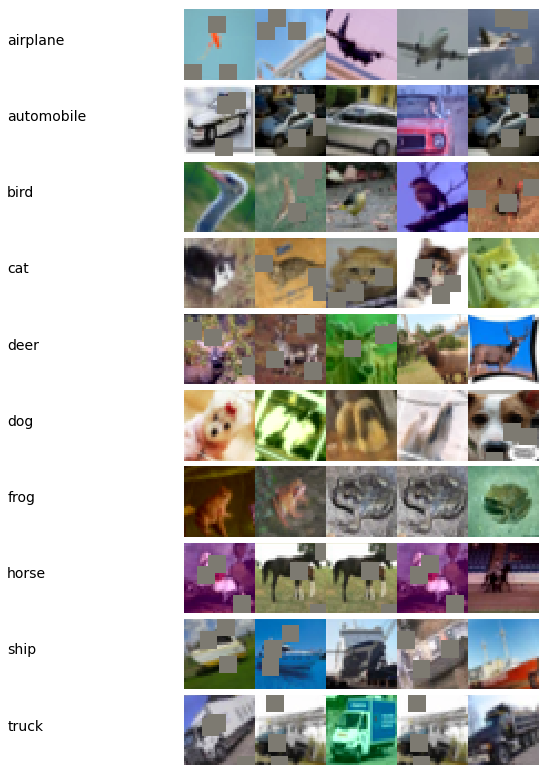

In [112]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [113]:
import rn
import torch
model = rn.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


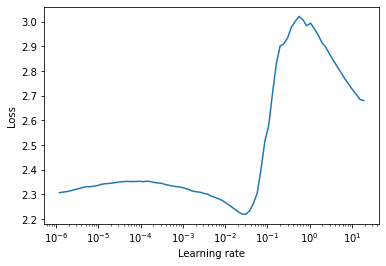

In [114]:
# LR finder fast ai approach
from lrfinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

In [116]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)

scheduler = ReduceLROnPlateau(optimizer, threshold=1e-7, mode='max', factor=0.95, patience=1, verbose=True)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.113537).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0118, Accuracy: 45.79%; Test set: Average loss: 1.1135, Accuracy: 60.63%
Learning Rate = 0.025119



Epoch: 2, Train set: Average loss: 0.0080, Accuracy: 64.23%; Test set: Average loss: 1.4889, Accuracy: 57.50%
Learning Rate = 0.025119



Validation loss decreased (1.113537 --> 0.790349).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0066, Accuracy: 70.90%; Test set: Average loss: 0.7903, Accuracy: 72.63%
Learning Rate = 0.025119



Epoch     4: reducing learning rate of group 0 to 2.3863e-02.
Validation loss decreased (0.790349 --> 0.612008).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0057, Accuracy: 74.70%; Test set: Average loss: 0.6120, Accuracy: 79.85%
Learning Rate = 0.023863



Validation loss decreased (0.612008 --> 0.588105).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0051, Accuracy: 77.30%; Test set: Average loss: 0.5881, Accuracy: 80.45%
Learning Rate = 0.023863



Epoch     6: reducing learning rate of group 0 to 2.2670e-02.
Epoch: 6, Train set: Average loss: 0.0047, Accuracy: 79.31%; Test set: Average loss: 0.6363, Accuracy: 79.41%
Learning Rate = 0.022670



Validation loss decreased (0.588105 --> 0.484642).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0043, Accuracy: 81.10%; Test set: Average loss: 0.4846, Accuracy: 83.36%
Learning Rate = 0.022670



Epoch     8: reducing learning rate of group 0 to 2.1536e-02.
Validation loss decreased (0.484642 --> 0.464307).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0040, Accuracy: 82.49%; Test set: Average loss: 0.4643, Accuracy: 84.41%
Learning Rate = 0.021536



Validation loss decreased (0.464307 --> 0.460028).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0037, Accuracy: 83.86%; Test set: Average loss: 0.4600, Accuracy: 84.46%
Learning Rate = 0.021536



Epoch    10: reducing learning rate of group 0 to 2.0459e-02.
Validation loss decreased (0.460028 --> 0.448488).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0035, Accuracy: 84.72%; Test set: Average loss: 0.4485, Accuracy: 85.09%
Learning Rate = 0.020459



Validation loss decreased (0.448488 --> 0.388683).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0032, Accuracy: 85.59%; Test set: Average loss: 0.3887, Accuracy: 86.83%
Learning Rate = 0.020459



Epoch    12: reducing learning rate of group 0 to 1.9436e-02.
Epoch: 12, Train set: Average loss: 0.0031, Accuracy: 86.28%; Test set: Average loss: 0.3918, Accuracy: 86.96%
Learning Rate = 0.019436



Epoch: 13, Train set: Average loss: 0.0028, Accuracy: 87.44%; Test set: Average loss: 0.3939, Accuracy: 87.41%
Learning Rate = 0.019436



Epoch    14: reducing learning rate of group 0 to 1.8465e-02.
Epoch: 14, Train set: Average loss: 0.0027, Accuracy: 87.87%; Test set: Average loss: 0.4019, Accuracy: 87.13%
Learning Rate = 0.018465



Epoch: 15, Train set: Average loss: 0.0025, Accuracy: 88.73%; Test set: Average loss: 0.3934, Accuracy: 87.47%
Learning Rate = 0.018465



Epoch    16: reducing learning rate of group 0 to 1.7541e-02.
Epoch: 16, Train set: Average loss: 0.0025, Accuracy: 89.03%; Test set: Average loss: 0.4581, Accuracy: 85.71%
Learning Rate = 0.017541



Validation loss decreased (0.388683 --> 0.365753).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0023, Accuracy: 89.69%; Test set: Average loss: 0.3658, Accuracy: 88.63%
Learning Rate = 0.017541



Epoch    18: reducing learning rate of group 0 to 1.6664e-02.
Epoch: 18, Train set: Average loss: 0.0022, Accuracy: 90.04%; Test set: Average loss: 0.3946, Accuracy: 88.05%
Learning Rate = 0.016664



Epoch: 19, Train set: Average loss: 0.0021, Accuracy: 90.73%; Test set: Average loss: 0.3826, Accuracy: 88.10%
Learning Rate = 0.016664



Epoch    20: reducing learning rate of group 0 to 1.5831e-02.
Epoch: 20, Train set: Average loss: 0.0020, Accuracy: 91.00%; Test set: Average loss: 0.4027, Accuracy: 87.28%
Learning Rate = 0.015831



Epoch: 21, Train set: Average loss: 0.0019, Accuracy: 91.69%; Test set: Average loss: 0.3878, Accuracy: 88.02%
Learning Rate = 0.015831



Epoch    22: reducing learning rate of group 0 to 1.5040e-02.
Validation loss decreased (0.365753 --> 0.364365).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0018, Accuracy: 91.87%; Test set: Average loss: 0.3644, Accuracy: 89.07%
Learning Rate = 0.015040



Validation loss decreased (0.364365 --> 0.349279).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0017, Accuracy: 92.29%; Test set: Average loss: 0.3493, Accuracy: 89.42%
Learning Rate = 0.015040



Epoch    24: reducing learning rate of group 0 to 1.4288e-02.
Validation loss decreased (0.349279 --> 0.327690).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0017, Accuracy: 92.65%; Test set: Average loss: 0.3277, Accuracy: 89.73%
Learning Rate = 0.014288



Validation loss decreased (0.327690 --> 0.321776).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0016, Accuracy: 92.87%; Test set: Average loss: 0.3218, Accuracy: 90.13%
Learning Rate = 0.014288



Epoch    26: reducing learning rate of group 0 to 1.3573e-02.
Epoch: 26, Train set: Average loss: 0.0016, Accuracy: 93.03%; Test set: Average loss: 0.3392, Accuracy: 90.05%
Learning Rate = 0.013573



Epoch: 27, Train set: Average loss: 0.0015, Accuracy: 93.55%; Test set: Average loss: 0.3420, Accuracy: 90.10%
Learning Rate = 0.013573



Epoch    28: reducing learning rate of group 0 to 1.2895e-02.
Validation loss decreased (0.321776 --> 0.319314).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0014, Accuracy: 93.68%; Test set: Average loss: 0.3193, Accuracy: 90.49%
Learning Rate = 0.012895



Validation loss decreased (0.319314 --> 0.305303).  Saving model ...
Epoch: 29, Train set: Average loss: 0.0013, Accuracy: 93.99%; Test set: Average loss: 0.3053, Accuracy: 90.70%
Learning Rate = 0.012895



Epoch    30: reducing learning rate of group 0 to 1.2250e-02.
Epoch: 30, Train set: Average loss: 0.0013, Accuracy: 94.31%; Test set: Average loss: 0.3059, Accuracy: 90.91%
Learning Rate = 0.012250



Epoch: 31, Train set: Average loss: 0.0012, Accuracy: 94.47%; Test set: Average loss: 0.3159, Accuracy: 90.90%
Learning Rate = 0.012250



Epoch    32: reducing learning rate of group 0 to 1.1637e-02.
Epoch: 32, Train set: Average loss: 0.0012, Accuracy: 94.69%; Test set: Average loss: 0.3222, Accuracy: 90.68%
Learning Rate = 0.011637



Epoch: 33, Train set: Average loss: 0.0012, Accuracy: 94.73%; Test set: Average loss: 0.3320, Accuracy: 90.61%
Learning Rate = 0.011637



Epoch    34: reducing learning rate of group 0 to 1.1055e-02.
Validation loss decreased (0.305303 --> 0.298030).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0011, Accuracy: 95.10%; Test set: Average loss: 0.2980, Accuracy: 91.33%
Learning Rate = 0.011055



Epoch: 35, Train set: Average loss: 0.0011, Accuracy: 95.07%; Test set: Average loss: 0.3094, Accuracy: 91.03%
Learning Rate = 0.011055



Epoch    36: reducing learning rate of group 0 to 1.0503e-02.
Epoch: 36, Train set: Average loss: 0.0011, Accuracy: 95.32%; Test set: Average loss: 0.3157, Accuracy: 90.88%
Learning Rate = 0.010503



Validation loss decreased (0.298030 --> 0.295609).  Saving model ...
Epoch: 37, Train set: Average loss: 0.0010, Accuracy: 95.67%; Test set: Average loss: 0.2956, Accuracy: 91.50%
Learning Rate = 0.010503



Epoch    38: reducing learning rate of group 0 to 9.9776e-03.
Epoch: 38, Train set: Average loss: 0.0010, Accuracy: 95.57%; Test set: Average loss: 0.3001, Accuracy: 91.21%
Learning Rate = 0.009978



Validation loss decreased (0.295609 --> 0.294723).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0010, Accuracy: 95.74%; Test set: Average loss: 0.2947, Accuracy: 91.60%
Learning Rate = 0.009978



Epoch    40: reducing learning rate of group 0 to 9.4787e-03.
Epoch: 40, Train set: Average loss: 0.0010, Accuracy: 95.79%; Test set: Average loss: 0.2963, Accuracy: 91.45%
Learning Rate = 0.009479



Epoch: 41, Train set: Average loss: 0.0009, Accuracy: 96.11%; Test set: Average loss: 0.3098, Accuracy: 91.55%
Learning Rate = 0.009479



Epoch    42: reducing learning rate of group 0 to 9.0048e-03.
Epoch: 42, Train set: Average loss: 0.0008, Accuracy: 96.36%; Test set: Average loss: 0.3034, Accuracy: 91.60%
Learning Rate = 0.009005



Epoch: 43, Train set: Average loss: 0.0008, Accuracy: 96.44%; Test set: Average loss: 0.3079, Accuracy: 91.54%
Learning Rate = 0.009005



Epoch    44: reducing learning rate of group 0 to 8.5545e-03.
Validation loss decreased (0.294723 --> 0.294566).  Saving model ...
Epoch: 44, Train set: Average loss: 0.0008, Accuracy: 96.36%; Test set: Average loss: 0.2946, Accuracy: 91.85%
Learning Rate = 0.008555



Validation loss decreased (0.294566 --> 0.288840).  Saving model ...
Epoch: 45, Train set: Average loss: 0.0008, Accuracy: 96.63%; Test set: Average loss: 0.2888, Accuracy: 91.82%
Learning Rate = 0.008555



Epoch    46: reducing learning rate of group 0 to 8.1268e-03.
Epoch: 46, Train set: Average loss: 0.0008, Accuracy: 96.61%; Test set: Average loss: 0.3125, Accuracy: 91.71%
Learning Rate = 0.008127



Epoch: 47, Train set: Average loss: 0.0007, Accuracy: 96.83%; Test set: Average loss: 0.2967, Accuracy: 91.74%
Learning Rate = 0.008127



Epoch    48: reducing learning rate of group 0 to 7.7205e-03.
Epoch: 48, Train set: Average loss: 0.0007, Accuracy: 96.84%; Test set: Average loss: 0.2944, Accuracy: 91.68%
Learning Rate = 0.007720



Validation loss decreased (0.288840 --> 0.287413).  Saving model ...
Epoch: 49, Train set: Average loss: 0.0007, Accuracy: 96.80%; Test set: Average loss: 0.2874, Accuracy: 92.13%
Learning Rate = 0.007720



Epoch    50: reducing learning rate of group 0 to 7.3344e-03.
Epoch: 50, Train set: Average loss: 0.0007, Accuracy: 96.90%; Test set: Average loss: 0.3047, Accuracy: 92.00%
Learning Rate = 0.007334



In [117]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.96896
0.9213


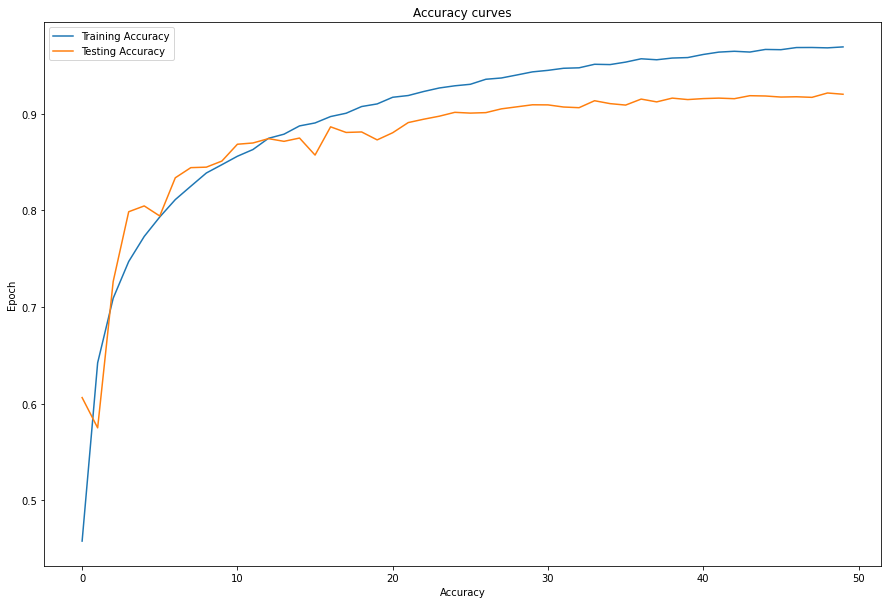

In [118]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

In [119]:
len(model.stats().get_misclassified_images())

25

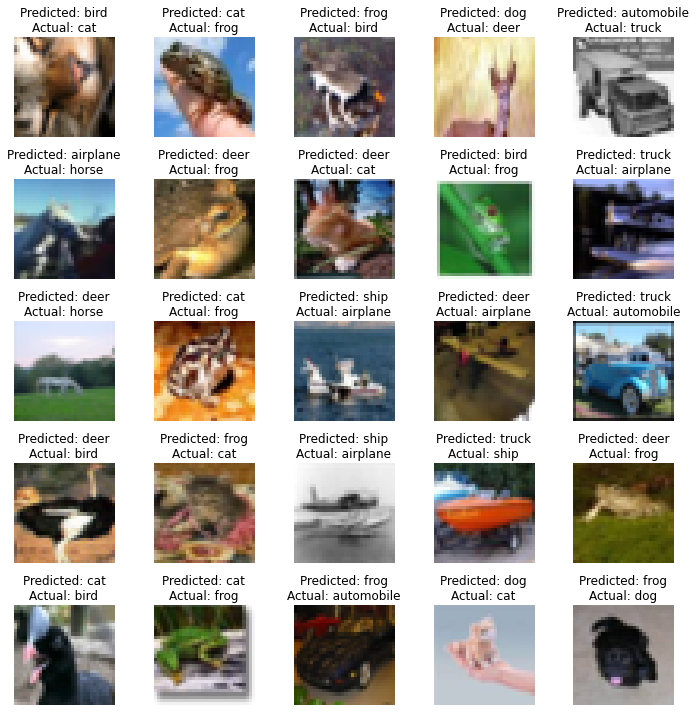

In [120]:
import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))

In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"])
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [122]:
print(target_classes)
print(pred_classes)

[3, 6, 2, 4, 9, 7, 6, 3, 6, 0, 7, 6, 0, 0, 1, 2, 3, 0, 8, 6, 2, 6, 1, 3, 5]
[2, 3, 6, 5, 1, 0, 4, 4, 2, 9, 4, 3, 8, 4, 9, 4, 6, 8, 9, 4, 3, 3, 6, 5, 6]


In [123]:
model.load_state_dict(torch.load(f"/content/drive/My Drive/{model.name}.pt"))

<All keys matched successfully>

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


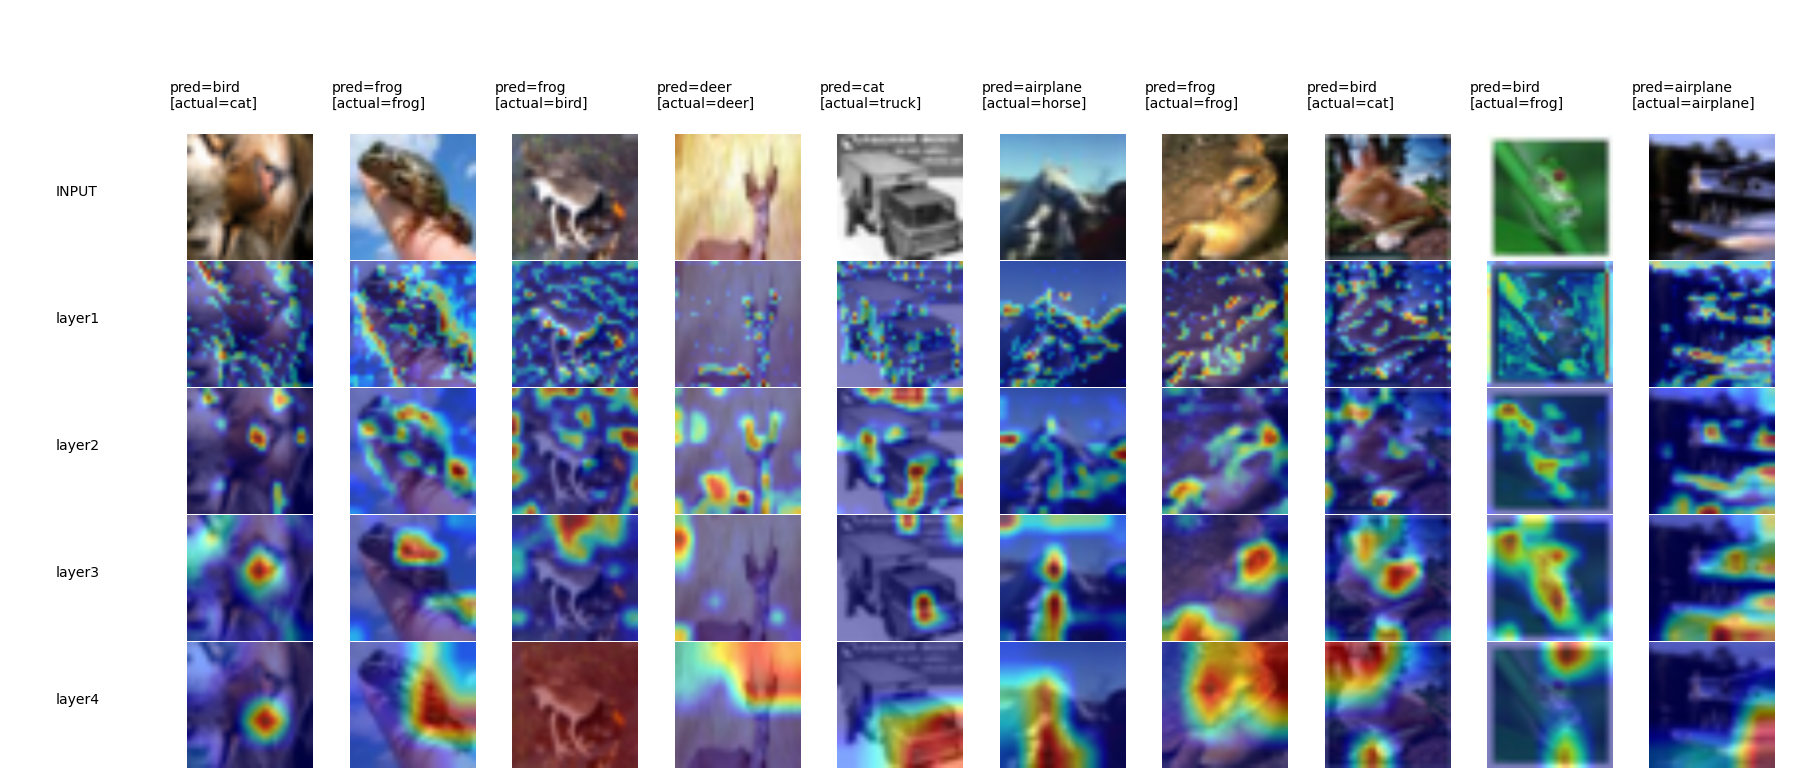

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


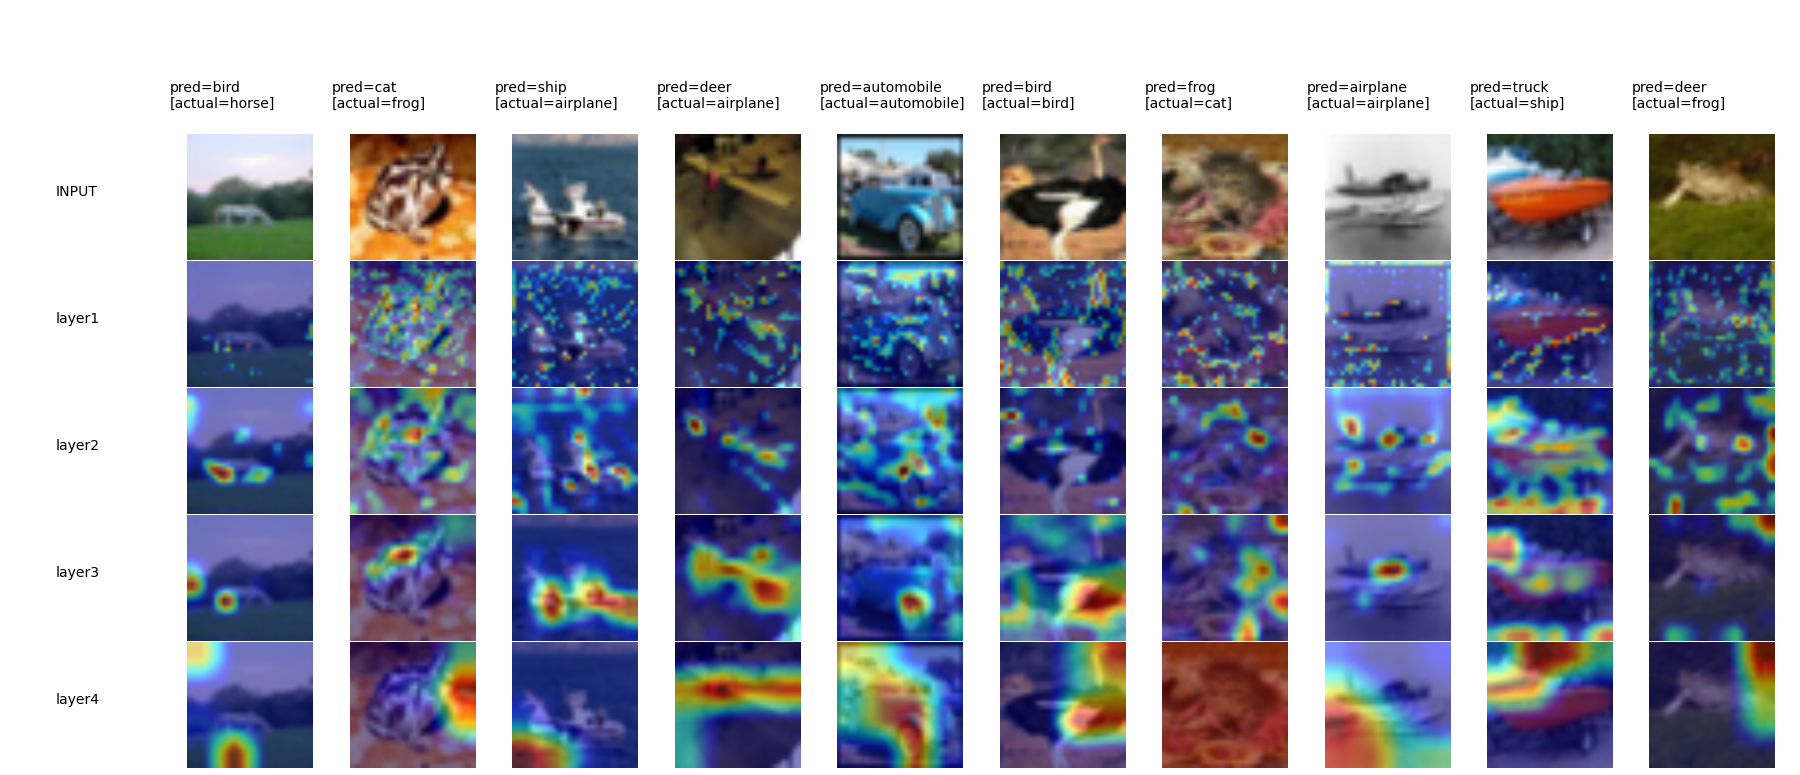

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


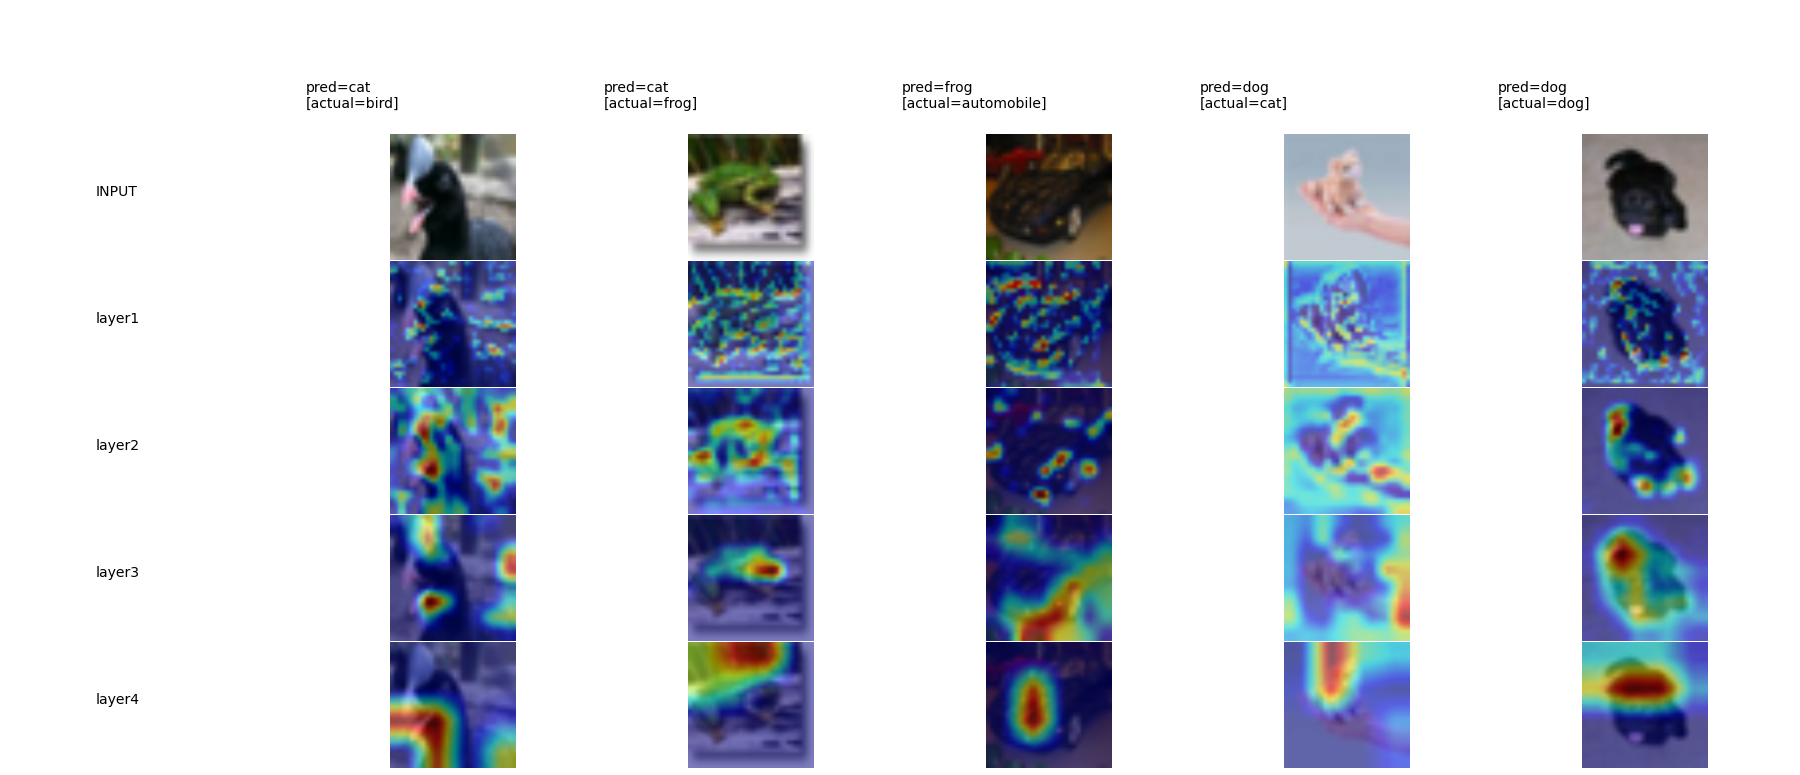

In [124]:
from gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)